# 1. INIT - Imports

In [1]:
import os
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pympler import asizeof
from visdom import Visdom
from copy import deepcopy
import time
import networkx as nx
import logging
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
from cmcrameri import cm
from itertools import combinations
from scipy import stats
from scipy.stats import pearsonr, linregress, t
from typing import List, Tuple
#this is set for the printing of Q-matrices via console
torch.set_printoptions(precision=3, sci_mode=False, linewidth=100)

from tqdm.auto import tqdm, trange

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#Uncomment if GPU is to be used - right now use CPU, as we have very small networks and for them, CPU is actually faster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#suppress scientific notation in printouts
np.set_printoptions(suppress=True)

# 2. INIT - Load data

In [2]:
init_color_hex: str = "#2f78b6" # hex color of init point (left top)
goal_color_hex: str = '#f0b226' # hex color of goal point (right bottom)
wall_color: list[float] = [0.7, 0.7, 0.7] # RGB color of walls

n_cell: int = 4 # how many original cells
grid_dim = n_cell * 2 - 1 # side length of the square gridworld, in the form of 2n-1
n_actions: int = 4 # how many actions are possible in each state
lava: bool = False #do we use lava states - i.e. accessible wall states - (True) or wall states (False)? (we now always use "False")
starting_state: int = 0
goal_state = grid_dim ** 2 - 1

# generation of maze
maze_gen: bool = False # generate wall_states? wall_state_dict {0: [], 1: [1], 2: [2], 3: [3], ... } consists of 
n_mazes: int = 3800

# rewards in the gridworld (-0.1, 100, -5)
step_reward: float = -0.1 # for taking a step
goal_reward: float = 2. # for reaching the goal
wall_reward: float = -1. # for bumping into a wall

# Net settings
input_neurons: int = 2 # for network init
output_neurons = n_actions # modeling the Q(s, a) value by the output neurons w.r.t. number of action
using_mazearray_as_concept: bool = False
using_mazearray_as_concept_str = "_fixedconcept" if using_mazearray_as_concept else ""
supervised_mazearray_as_concept: bool = False
supervised_mazearray_as_concept_str = "_supervisedconcept" if supervised_mazearray_as_concept else ""
concept_size: int = 64 if (using_mazearray_as_concept is False and supervised_mazearray_as_concept is False) else grid_dim * grid_dim # the concept vector size of CA-TS DQN
supervised_1st_common_concept: bool = True
supervised_1st_common_concept_str = "_supervised1stcommon" if supervised_1st_common_concept else ""
using_concept_eps: bool = True
concept_eps: float = 1.0
concept_eps_str = f"_cpteps{concept_eps}" if using_concept_eps else ""
using_res: bool = True
res_str = "_res" if using_res else ""
hidden_dims: list = [768] * 18
dim_str = "-".join(str(d) for d in hidden_dims)
q_s2a: bool = False # whether using Q(s) -> a: True or Q(s, a): False
q_str = "" if q_s2a else "_sa2q"
n_agents: int = 5 # how many anegts used in communication games
i_agent: int = 2 # agent index == 0, i.e. no group
n_unique: int = 20 # unique mazes learned by each agent
n_group: int = 11
group_str = f"group{n_group}/" if i_agent != 0 else ""

# training settings
train_dqn: bool = False
batch_size: int = 512 # 0 indicates using all data in buffer as a batch
epsilon: float = 0.1 # greedy action policy
lr: float = 1e-4 # learning rate
gamma_bellman: float = 0.9999 # bellman equation
target_replace_steps: int = 0 # renew target_net by eval_net after how many iter times, 0 indicates directly using eval_net as target_net
memory_capacity: int = 0 # number transitions stored, 0 indicates pre-store all transitions in memory (change training mode as epoch manner)
cap_str = "" if memory_capacity != 0 else "_prestore"
upper_steps: int = 100 # truncated steps
n_episode: int = 100000
all_action_one_state: bool = True
ckpt_file: str = f"agent_ckpt/{group_str}ckpt{i_agent}of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}_lr{lr}_epsi{n_episode}_gamma{gamma_bellman}_bs{batch_size}_tr{target_replace_steps}.pt"
memory_file: str = f"agent_memory/{group_str}memory{i_agent}of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}_lr{lr}_epsi{n_episode}_gamma{gamma_bellman}_bs{batch_size}_tr{target_replace_steps}.npy"
log_file: str = f"agent_log/{group_str}log{i_agent}of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}_lr{lr}_epsi{n_episode}_gamma{gamma_bellman}_bs{batch_size}_tr{target_replace_steps}.log"


# communication testing
load_ckpt: bool = True
load_concepts_from_others: bool = True
rand_unknown_concepts: bool = False
ep_r_idx_str: str = "after" if load_concepts_from_others else "before"
test_only_unique: bool = True
unique_str: str = "unique" if test_only_unique else "all"
save_ep_r: bool = False
comm_trail_num: int = 10
ep_r_file: str = f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_{ep_r_idx_str}_test_{unique_str}_trail{comm_trail_num}.pt"

# CA-TS generalization ability test
test_concept_generalization: bool = False
learn_old_mazes: bool = False
n_generalization_mazes: int = 5
memory_test_capacity: int = 0
n_test_episode: int = 10
lr_test: float = 1e-3
test_rand_start: bool = False

In [3]:
def get_unique_indices(n_mazes, n_agents, i_agent, n_unique):
    common_end = n_mazes - n_agents * n_unique
    unique_start = common_end + (i_agent - 1) * n_unique
    unique_end = unique_start + n_unique

    return list(range(unique_start, unique_end))


# 3. ANALYSIS - Place Cell

In [18]:
# dict[maze_index]
agenti_all_trajectories_activations = torch.load(f"agent_activations/{group_str}activations{i_agent}of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}.pt")


/tmp/ipykernel_3927477/987996178.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agenti_all_trajectories_activations = torch.load(f"agent_activations/{group_str}activati

In [ ]:
len(agenti_all_trajectories_activations[0]) # Dict[maze_index], travel through, total 3720

In [ ]:
len(agenti_all_trajectories_activations[0][0]['activations']) # Dict[maze_index][steps]['activations'][num_layers]

In [ ]:
agenti_all_trajectories_activations[0][0]['activations'][16].shape

In [ ]:
agenti_all_trajectories_activations[0][0]['activations'][0][0][0] # [row][0][col]

In [ ]:
float(agenti_all_trajectories_activations[0][0]['activations'][0][0][0])

In [19]:
# neuron_index = 768 # range from 0 to 13823 (18 * 768 - 1)
def get_coordinates_from_index(index):
    """
    Convert a linear index to (layer, neuron) coordinates in an 18x768 matrix.
    
    Args:
        index (int): Linear index from 0 to 13823 (18*768-1)
        
    Returns:
        tuple: (layer, neuron) coordinates where row is 0-17, col is 0-767
    """
    if index < 0 or index > 13823:
        raise ValueError("Index must be between 0 and 13823")

    layer = index // 768
    neuron = index % 768

    return (layer, neuron)

import random

def sample_random_neuron_indices(num_layers=18, num_per_layer=10, neurons_per_layer=768, seed=None):
    """
    Randomly sample neuron indices from each layer.

    Args:
        num_layers (int): Number of layers (default 18)
        num_per_layer (int): Number of neurons to sample per layer (default 10)
        neurons_per_layer (int): Number of neurons per layer (default 768)
        seed (int, optional): Random seed for reproducibility

    Returns:
        list: List of linear indices (length num_layers * num_per_layer)
    """
    if seed is not None:
        random.seed(seed)
    indices = []
    for layer in range(num_layers):
        # Sample without replacement
        sampled_neurons = random.sample(range(neurons_per_layer), num_per_layer)
        for neuron in sampled_neurons:
            index = layer * neurons_per_layer + neuron
            indices.append(index)
    return indices

# Example usage:
# random_indices = sample_random_neuron_indices()


In [20]:
def count_state_frequencies(trajectories_activations):
    """
    Count the frequency of 'state_int' values in all step_items.

    Args:
        trajectories_activations: dict, format {maze_key: [step_items]}
                                  Each step_item is a dict containing the 'state_int' key.

    Returns:
        dict: Keys are state_int values (0-48), values are the corresponding frequencies.
    """
    # Initialize frequency dictionary for all possible states 0-48
    state_counts = {i: 0 for i in range(49)}  # 49 states from 0 to 48

    # Iterate over all mazes
    for maze_key, maze_trajectory in trajectories_activations.items():
        # Iterate over all steps in the maze
        for step_item in maze_trajectory:
            # Get the state_int value for the current step
            if 'state_int' in step_item:
                state_int = step_item['state_int']
                # Ensure state_int is within the valid range
                if 0 <= state_int <= 48:
                    state_counts[state_int] += 1
                else:
                    print(f"Warning: Found state_int {state_int} outside expected range [0, 48]")

    return state_counts



In [21]:
def count_neuron_activations(trajectories_activations, neuron_index):
    """
    Count the averaged activations at each 'state_int' values in all step_items.

    Args:
        trajectories_activations: dict, format {maze_key: [step_items]}
                                  Each step_item is a dict containing the 'state_int' key.
        neuron_index: int, must be decomposed to 

    Returns:
        dict: Keys are state_int values (0-48), values are the corresponding frequencies.
    """
    row, col = get_coordinates_from_index(neuron_index)
    # Initialize frequency dictionary for all possible states 0-48
    state_counts = {i: 0 for i in range(49)}  # 49 states from 0 to 48
    activation_per_state = {i: 0. for i in range(49)}
    averaged_activation_per_state = {i: 0. for i in range(49)}

    sum_state_counts = 0.
    sum_activations = 0.
    averaged_activations = 0.
    spatial_mutual_information = 0.

    # Iterate over all mazes
    for maze_key, maze_trajectory in trajectories_activations.items():
        # Iterate over all steps in the maze
        for step_item in maze_trajectory:
            state_int = step_item['state_int']
            activations = step_item['activations']
            # Ensure state_int is within the valid range
            if 0 <= state_int <= 48:
                state_counts[state_int] += 1
            else:
                print(f"Warning: Found state_int {state_int} outside expected range [0, 48]")
            activation_per_state[state_int] += float(activations[row][0][col])

    for i in range(49):
        sum_activations += activation_per_state[i]
        if state_counts[i] != 0:
            averaged_activation_per_state[i] = activation_per_state[i] / state_counts[i]
            # print(f"state {i}, lambda_i {averaged_activation_per_state[i]}")
            if averaged_activation_per_state[i] > 0:
                sum_state_counts += state_counts[i]
    if sum_state_counts > 0:
        averaged_activations = sum_activations / sum_state_counts
        for i in range(49):
            if state_counts[i] != 0 and averaged_activation_per_state[i] > 0:
                lambda_i = averaged_activation_per_state[i]
                spatial_mutual_information += (state_counts[i] / sum_state_counts) * (lambda_i / averaged_activations) * mt.log2(lambda_i / averaged_activations)
        
        return averaged_activation_per_state, spatial_mutual_information
    
    else:
        return None, None



In [22]:
def plot_spatial_activation_map(neuroni_activations: dict, title: str = "Spatial Activation Map"):
    """
    Plots a 7x7 spatial activation map from a dictionary of activations.

    The grid is indexed from 0 (bottom-left) to 48 (top-right).

    Args:
        neuroni_activations (dict): A dictionary with keys 0-48 and float activation values.
        title (str): The title for the plot.
    """
    # Create a 7x7 grid to store the activation values
    grid_data = np.zeros((7, 7))

    # Populate the grid with activation values
    for state, activation in neuroni_activations.items():
        if 0 <= state <= 48:
            # Convert state index to (row, col) coordinates
            # The origin is at the bottom-left
            row = state // 7
            col = state % 7
            grid_data[row, col] = activation
        else:
            print(f"Warning: State {state} is outside the expected 0-48 range and will be ignored.")

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(8, 7), dpi=150)
    im = ax.imshow(grid_data, cmap='jet', origin='lower', aspect='equal')

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Activation Value')

    # Set axis labels and ticks
    ax.set_xticks(np.arange(7))
    ax.set_yticks(np.arange(7))
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    
    # Add grid lines
    ax.set_xticks(np.arange(-.5, 7, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 7, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', size=0)

    # Add state numbers to each cell for clarity
    for i in range(7):
        for j in range(7):
            state_idx = i * 7 + j
            # Adjust text color based on background luminance for better visibility
            # Normalize value to 0-1 range for comparison
            normalized_val = (grid_data[i, j] - grid_data.min()) / (grid_data.max() - grid_data.min())
            text_color = "w" if normalized_val < 0.5 else "black"
            # ax.text(j, i, str(state_idx), ha='center', va='center', color=text_color)

    ax.set_title(title)
    plt.tight_layout()
    plt.show()


In [28]:
# Use the function to count frequencies
state_frequencies = count_state_frequencies(agenti_all_trajectories_activations)

neuron_index = 13164
neuroni_activations, neuroni_MI = count_neuron_activations(agenti_all_trajectories_activations, neuron_index)

if neuroni_MI is not None:
    # Print the results
    print(f"Neuron {neuron_index} spatial mutual information {neuroni_MI}")
    print(f"Neuron {neuron_index} activations and State frequencies:")
    print("State | Frequency | Activation Value")
    print("------|-----------|-----------------")
    for state, freq in state_frequencies.items():
        print(f"{state:5d} | {freq:9d} | {neuroni_activations[state]:.6f}")

    # Calculate total steps and some statistics
    total_steps = sum(state_frequencies.values())
    non_zero_states = sum(1 for freq in state_frequencies.values() if freq > 0)

    print(f"\nSummary:")
    print(f"Total steps: {total_steps}")
    print(f"States visited: {non_zero_states}/49")
    print(f"States never visited: {49 - non_zero_states}")

    # Find the most and least visited states (excluding states with zero frequency)
    if total_steps > 0:
        max_freq_state = max(state_frequencies.items(), key=lambda x: x[1])
        min_freq_state = min((item for item in state_frequencies.items() if item[1] > 0), 
                            key=lambda x: x[1], default=None)
        
        print(f"Most visited state: {max_freq_state[0]} (frequency: {max_freq_state[1]})")
        if min_freq_state:
            print(f"Least visited state (non-zero): {min_freq_state[0]} (frequency: {min_freq_state[1]})")

    plot_spatial_activation_map(neuroni_activations, title=f"Spatial Activation Map for Neuron {neuron_index}")

else:
    print(f"Neuron {neuron_index} has no selectivity")


Neuron 13164 has no selectivity


In [27]:
# --------- New code: plot activation maps for a list of neuron indices as subplots (column-major order) ---------
# Suppose you have a list of neuron indices called `neuron_indices_list` (length 180)
# Example: neuron_indices_list = [ ... ]  # length 180

# Please make sure to define neuron_indices_list before running this code

neuron_indices_list = sample_random_neuron_indices(num_layers=18, num_per_layer=10, neurons_per_layer=768, seed=42)

if 'neuron_indices_list' in locals() and len(neuron_indices_list) == 180:
    n_rows, n_cols = 10, 18  # 10 rows, 18 columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows), dpi=300)
    fig.suptitle("Spatial Activation Maps for 180 Neurons", fontsize=18, y=1.02)
    for idx, neuron_index in enumerate(neuron_indices_list):
        # Fill subplots in column-major order
        col = idx // n_rows
        row = idx % n_rows
        ax = axes[row, col]
        neuroni_activations, neuroni_MI = count_neuron_activations(agenti_all_trajectories_activations, neuron_index)
        # Prepare grid data
        grid_data = np.full((7, 7), np.nan)
        if neuroni_activations is not None:
            for state, activation in neuroni_activations.items():
                if 0 <= state <= 48:
                    r = state // 7
                    c = state % 7
                    grid_data[r, c] = activation
            im = ax.imshow(grid_data, cmap='jet', origin='lower', aspect='equal', vmin=np.nanmin(grid_data), vmax=np.nanmax(grid_data))
        else:
            im = ax.imshow(np.zeros((7, 7)), cmap='gray', origin='lower', aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"n{neuron_index}", fontsize=8)
    plt.tight_layout(w_pad=0.5, h_pad=0.5)
    plt.subplots_adjust(top=0.93)
    plt.show()
else:
    print("Please define neuron_indices_list as a list of 180 neuron indices before running this code.")

In [25]:
neuron_indices_list

[654,
 114,
 25,
 759,
 281,
 250,
 228,
 142,
 754,
 104,
 1460,
 1526,
 1326,
 857,
 1372,
 1200,
 800,
 798,
 863,
 991,
 1774,
 2053,
 2152,
 1563,
 2110,
 1739,
 2269,
 2201,
 2254,
 2094,
 2733,
 2529,
 2763,
 2907,
 2588,
 2310,
 2467,
 3018,
 2736,
 2652,
 3356,
 3231,
 3292,
 3416,
 3176,
 3166,
 3461,
 3171,
 3439,
 3424,
 4458,
 4110,
 3884,
 4587,
 4310,
 4389,
 3967,
 4227,
 3920,
 4405,
 4908,
 5251,
 5241,
 4978,
 5199,
 4804,
 5329,
 4679,
 4654,
 5285,
 5609,
 5672,
 5457,
 5614,
 5479,
 5765,
 5660,
 5840,
 6026,
 5749,
 6310,
 6523,
 6507,
 6358,
 6830,
 6417,
 6862,
 6843,
 6807,
 6217,
 7535,
 7562,
 7087,
 7458,
 7658,
 7162,
 7079,
 7385,
 7300,
 7188,
 8335,
 8384,
 8250,
 7904,
 8381,
 8012,
 7737,
 7914,
 7712,
 8003,
 8858,
 8722,
 8515,
 8664,
 9028,
 9183,
 8770,
 8665,
 9119,
 8959,
 9621,
 9874,
 9685,
 9362,
 9487,
 9358,
 9468,
 9978,
 9790,
 9767,
 10253,
 10748,
 10582,
 10422,
 10581,
 10392,
 10354,
 10208,
 10125,
 10505,
 11257,
 10845,
 10800,
 1

In [ ]:
# MI_per_neuron = {}
# for neuron_index in trange(18 * 768):
#     _, neuroni_MI = count_neuron_activations(agenti_all_trajectories_activations, neuron_index)
#     MI_per_neuron[neuron_index] = neuroni_MI

# torch.save(MI_per_neuron, f"agent_activations/{group_str}hist_acti{i_agent}of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}.pt")

MI_per_neuron = torch.load(f"agent_activations/{group_str}hist_acti{i_agent}of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}.pt")

In [ ]:
nonzero_MI_values = [v for v in MI_per_neuron.values() if v is not None and v != 0]
plt.figure(figsize=(8, 5))
plt.hist(nonzero_MI_values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Mutual Information (MI)')
plt.ylabel('Number of Neurons')
plt.title('Histogram of MI per Neuron (Nonzero MI)')
plt.tight_layout()
plt.show()

# 新增：返回两个index的函数
def get_indices_by_MI(MI_per_neuron):
    """
    返回两个列表：
    - 第一个列表是所有value大于3的neuron的index
    - 第二个列表是所有value介于0到0.1之间（包含0，不包含0.1）的neuron的index
    """
    idx_gt2 = [idx for idx, v in MI_per_neuron.items() if v is not None and v > 2]
    idx_0_01 = [idx for idx, v in MI_per_neuron.items() if v is not None and 0 <= v < 0.1]
    return idx_gt2, idx_0_01

# 用法示例
indices_gt2, indices_0_01 = get_indices_by_MI(MI_per_neuron)
print(f"MI > 2 的neuron数量: {len(indices_gt2)}, index {indices_gt2[3]}")
print(f"0 <= MI < 0.1 的neuron数量: {len(indices_0_01)}, index {indices_0_01[2]}")

# 4. ANALYSIS - Successful rate t-test

In [ ]:
# Extract the two lists
sample1 = [0.5875, 0.575, 0.6, 0.6625, 0.6625]

# --- Test 1: Check if the mean of each sample is significantly greater than zero ---
# We use a one-sample t-test.
# H0: The mean of the sample is equal to 0.
# H1: The mean of the sample is greater than 0.

print("--- One-sample t-tests (mean > 0) ---")
alpha = 0.05 # Significance level

# For sample 1
# The 'alternative' parameter is set to 'greater' for a one-sided test.
t_statistic_s1, p_value_s1 = stats.ttest_1samp(sample1, 0, alternative='greater')
print(f"Sample 1: t-statistic = {t_statistic_s1:.4f}, p-value = {p_value_s1:.4f}")
print(f'mean {np.mean(sample1):.2f}, std {np.std(sample1):.2f}')
if p_value_s1 < alpha:
    print("  The mean of Sample 1 is significantly greater than 0.")
else:
    print("  There is not enough evidence to say the mean of Sample 1 is significantly greater than 0.")

print("-" * 40)


# 5. ANALYSIS - Compositionality

## Randomly Chosen samples in commons
Using full Q-matrix

/tmp/ipykernel_3927477/804524410.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  concepts = torch.load(f'agent_ckpt/{group_str}concepts_of_all.pt')
/tmp/ipykernel_392747

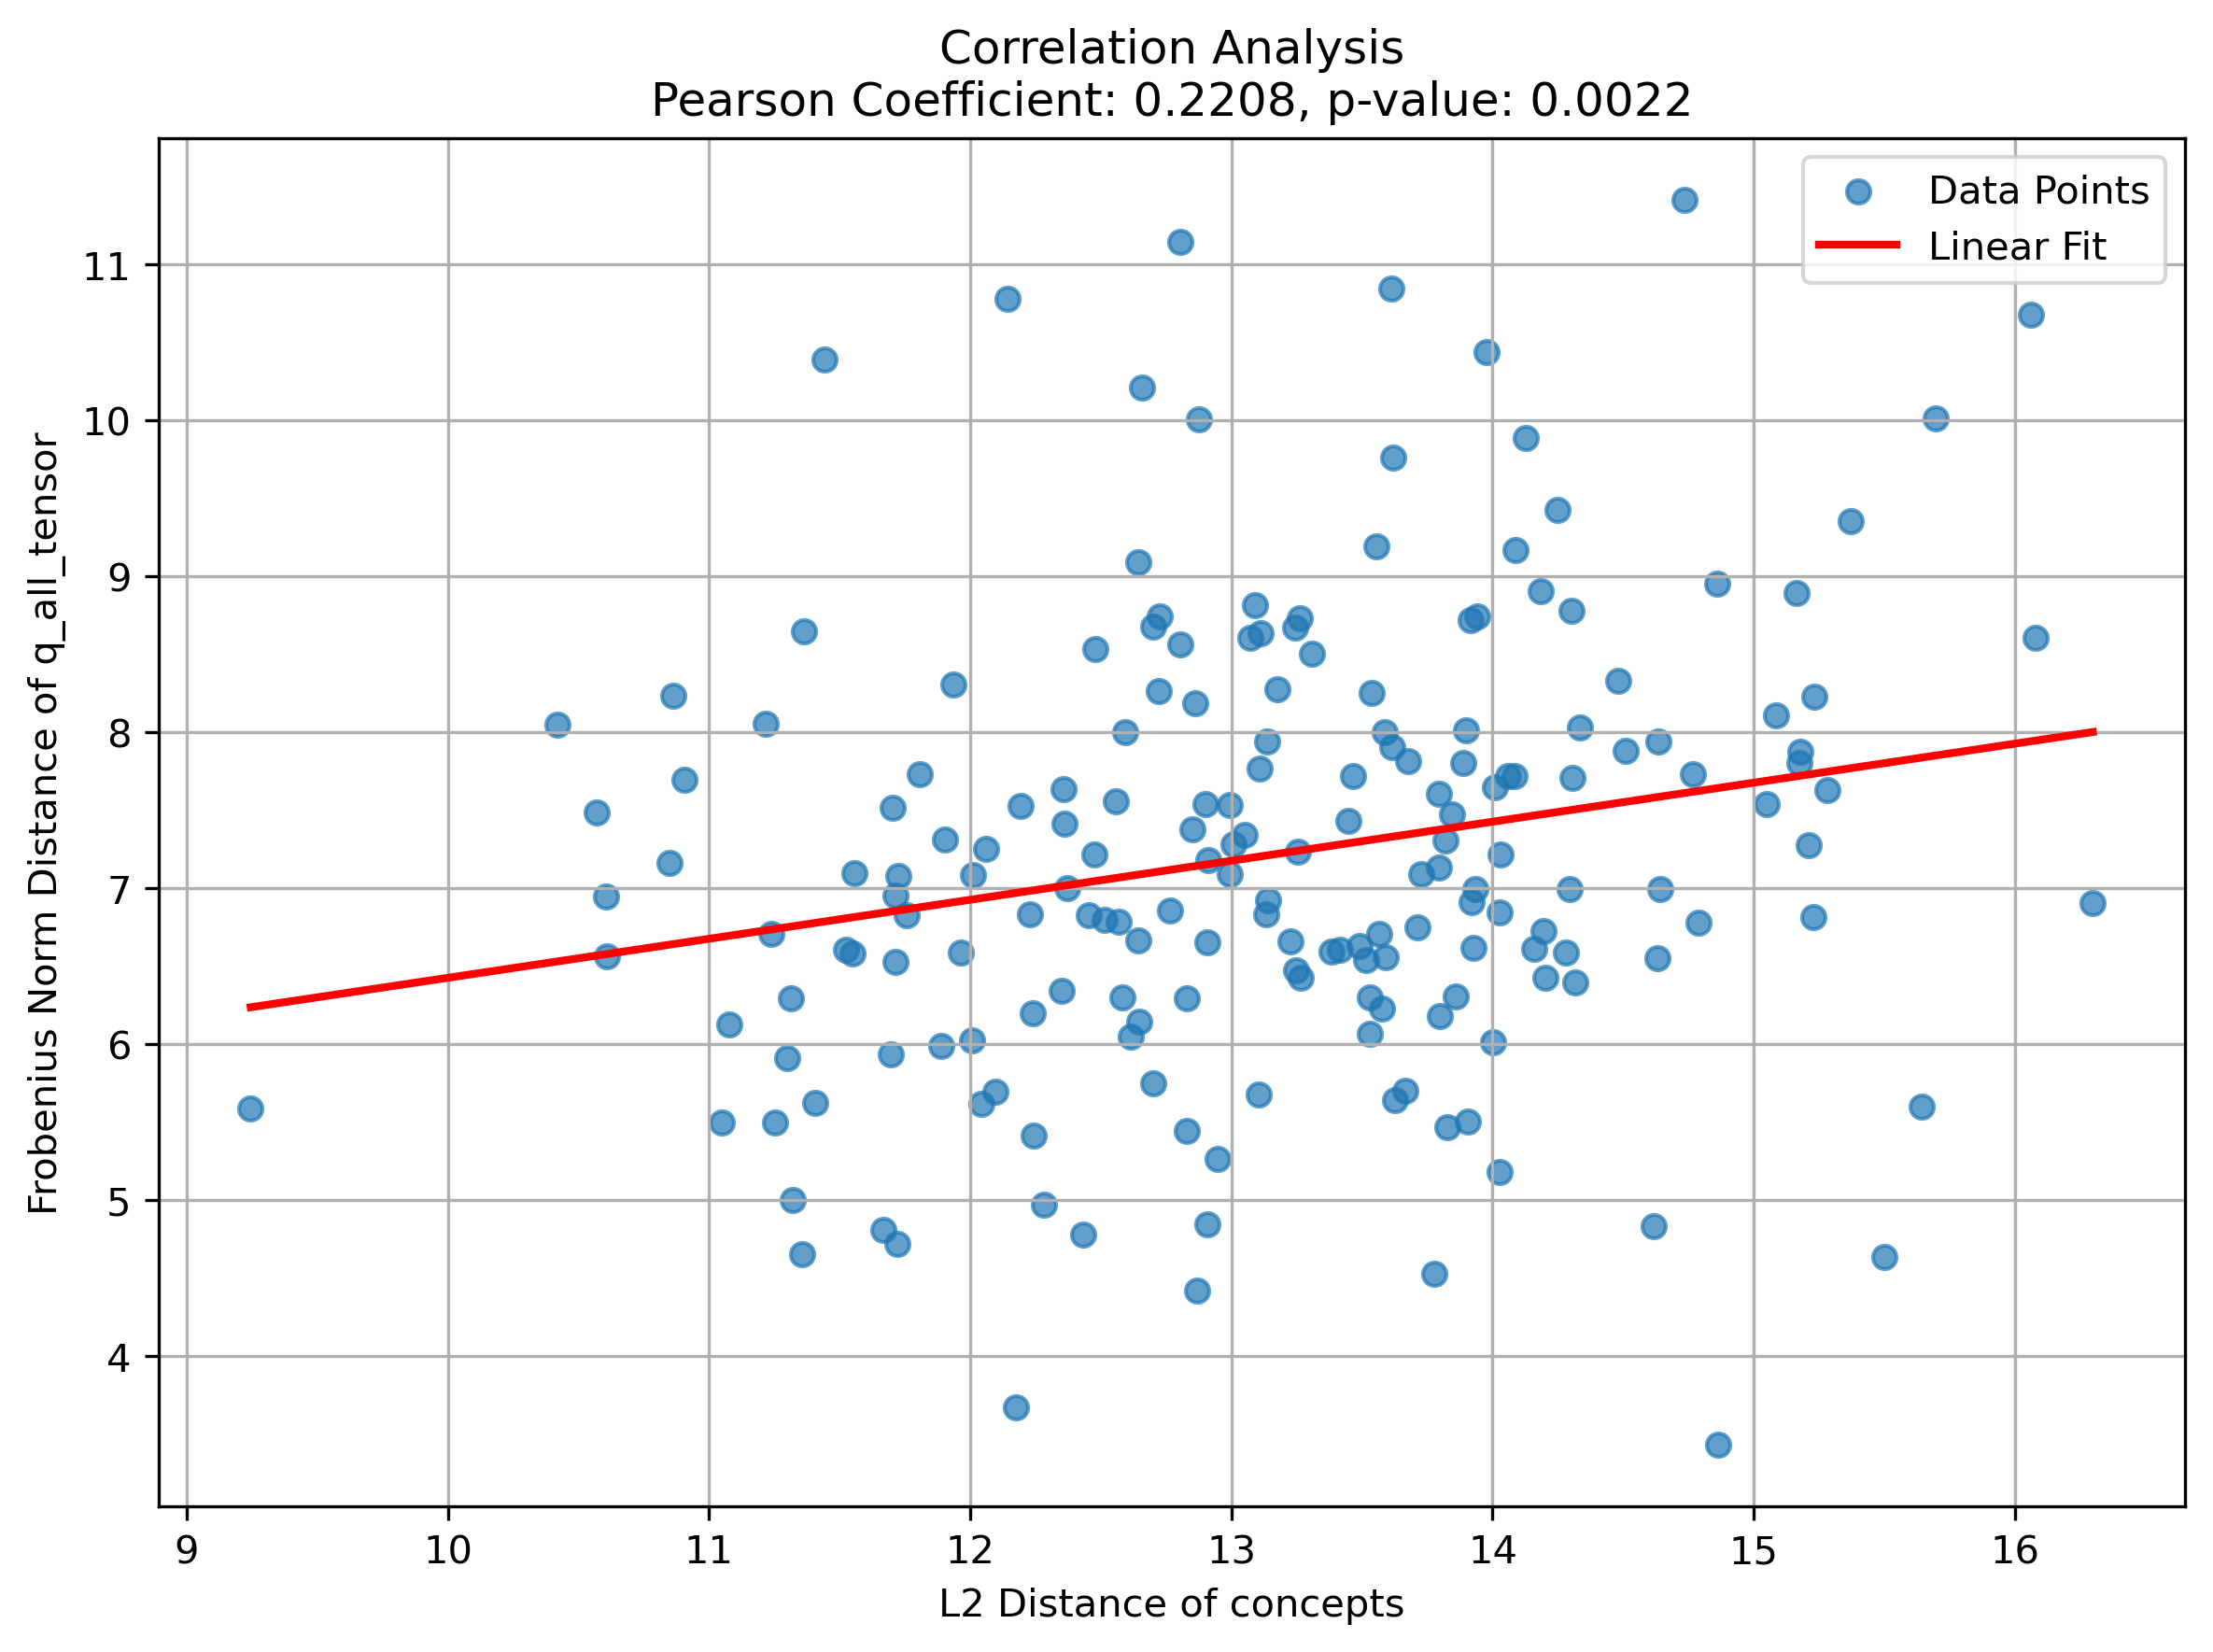

Linear Fit Equation: y = 0.2502x + 3.9238
Pearson Correlation Coefficient: 0.2208
p-value: 0.0022
Significant correlation


In [5]:
concepts = torch.load(f'agent_ckpt/{group_str}concepts_of_all.pt')
all_q_tensor = {}
for i in range(n_agents):
    ii_agent = i + 1
    tmp_all_q = torch.load(f'agent_ckpt/{group_str}qmatrix_{ii_agent}of{n_agents}.pt')
    all_q_tensor[ii_agent] = tmp_all_q

using_subQ = True
using_random_concept = False
num_sample = 20
# i_agent = 2

valid_indices = []
for i in range(48): # not include Q(49, actions)
    row = i // 7  # Original row in 7x7 grid (0 at bottom to 6 at top)
    col = i % 7   # Column in 7x7 grid (0 at left to 6 at right)
    if row % 2 == 0 and col % 2 == 0:  # Select odd-numbered rows/columns (0,2,4,6)
        valid_indices.append(i)

# concepts_subset = concepts[:3700].cpu()  # Ensure on CPU
# q_subset = all_q_tensor[i_agent][:3700].cpu()

# Randomly select num_sample sample indices
# selected_indices = random.sample(range(3700), num_sample)
selected_indices = get_unique_indices(n_mazes, n_agents, i_agent, n_unique)

# Extract corresponding samples
if using_random_concept:
    concepts_samples = torch.randn_like(concepts[selected_indices])
else:
    concepts_samples = concepts[selected_indices]  # shape: (num_sample, 64)

q_samples = all_q_tensor[i_agent][selected_indices]  # shape: (num_sample, 49, 4)
if using_subQ:
    q_samples = q_samples[:,valid_indices,:]

# Calculate distances for all pairs
x_distances = []  # L2 distances
y_distances = []  # Frobenius norm distances

for i, j in combinations(range(num_sample), 2):
    # Calculate L2 distance for concepts
    c_i = concepts_samples[i]
    c_j = concepts_samples[j]
    l2_dist = torch.norm(c_i - c_j, p=2).item()
    x_distances.append(l2_dist)
    
    # Calculate Frobenius norm distance for all_q_tensor
    q_i = q_samples[i]
    q_j = q_samples[j]
    frob_dist = torch.norm(q_i - q_j, p='fro').item()
    y_distances.append(frob_dist)

# Linear regression
x = np.array(x_distances)
y = np.array(y_distances)
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Calculate Pearson correlation coefficient
corr_coef, p_value = pearsonr(x, y)

# 7. Plot scatter diagram and regression line
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(x, y, alpha=0.7, label='Data Points')
plt.plot(sorted(x), polynomial(sorted(x)), 'r-', lw=2, label='Linear Fit')
plt.xlabel('L2 Distance of concepts')
plt.ylabel('Frobenius Norm Distance of q_all_tensor')
plt.title(f'Correlation Analysis\nPearson Coefficient: {corr_coef:.4f}, p-value: {p_value:.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Output statistical results
print(f"Linear Fit Equation: y = {coefficients[0]:.4f}x + {coefficients[1]:.4f}")
print(f"Pearson Correlation Coefficient: {corr_coef:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"{'Significant correlation' if p_value < 0.05 else 'No significant correlation'}")

In [ ]:
using_subQ = True
using_random_concept = False
num_sample = 20
i_agent = 4

valid_indices = []
for i in range(48): # not include Q(49, actions)
    row = i // 7  # Original row in 7x7 grid (0 at bottom to 6 at top)
    col = i % 7   # Column in 7x7 grid (0 at left to 6 at right)
    if row % 2 == 0 and col % 2 == 0:  # Select odd-numbered rows/columns (0,2,4,6)
        valid_indices.append(i)

# concepts_subset = concepts[:3700].cpu()  # Ensure on CPU
# q_subset = all_q_tensor[i_agent][:3700].cpu()

# Randomly select num_sample sample indices
# selected_indices = random.sample(range(3700), num_sample)
selected_indices = get_unique_indices(n_mazes, n_agents, i_agent, n_unique)

if using_random_concept:
    concepts_samples = torch.randn_like(concepts[selected_indices])
else:
    concepts_samples = concepts[selected_indices]

q_samples = all_q_tensor[i_agent][selected_indices]
if using_subQ:
    q_samples = q_samples[:,valid_indices,:]

x_distances = []
y_distances = []

# Check if num_sample is sufficient for combinations
if num_sample < 2:
    raise ValueError("num_sample must be at least 2 to form pairs for distance calculation.")

for i, j in combinations(range(num_sample), 2):
    c_i = concepts_samples[i]
    c_j = concepts_samples[j]
    l2_dist = torch.norm(c_i - c_j, p=2).item()
    x_distances.append(l2_dist)
    
    q_i = q_samples[i]
    q_j = q_samples[j]
    frob_dist = torch.norm(q_i - q_j, p='fro').item()
    y_distances.append(frob_dist)

x_np = np.array(x_distances)
y_np = np.array(y_distances)

if len(x_np) < 2: # Regression needs at least 2 points
    print("Not enough data points for regression (less than 2). Skipping analysis.")
    # Optionally, you can exit or plot just the points if they exist
    if len(x_np) > 0:
        plt.figure(figsize=(8, 6), dpi=300)
        plt.scatter(x_np, y_np, alpha=0.7, label='Data Points')
        plt.xlabel('L2 Distance of concepts')
        plt.ylabel('Frobenius Norm Distance of q_all_tensor')
        plt.title('Correlation Analysis (Not enough data for regression)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    exit()


# --- Linear regression using scipy.stats.linregress ---
slope, intercept, r_value, p_value_slope, stderr_slope = linregress(x_np, y_np)
beta_slope = slope # Beta is the slope

# Calculate 95% Confidence Interval for the slope (beta)
n_points = len(x_np)
alpha_ci = 0.05 # For 95% CI
t_critical_slope = t.ppf(1 - alpha_ci / 2, df=n_points - 2)
beta_ci_lower = beta_slope - t_critical_slope * stderr_slope
beta_ci_upper = beta_slope + t_critical_slope * stderr_slope
conf_int_slope = (beta_ci_lower, beta_ci_upper)

# --- Calculate Confidence Interval for the regression line (for plotting) ---
# Predicted y values from our regression
y_pred_line = intercept + slope * x_np

# Residuals
residuals = y_np - y_pred_line

# Residual standard error (RSE) or standard error of the estimate
# s = sqrt(sum(residuals^2) / (n-2))
s_err = np.sqrt(np.sum(residuals**2) / (n_points - 2))

# For plotting the CI band smoothly, create a range of x values
x_plot = np.linspace(x_np.min(), x_np.max(), 100)
y_plot_pred = intercept + slope * x_plot

# Calculate the CI for each point in x_plot
mean_x = np.mean(x_np)
ssx = np.sum((x_np - mean_x)**2)

# Margin of error for the regression line CI
# ME = t_critical * s_err * sqrt(1/n + (x_h - mean_x)^2 / ssx)
# Note: t_critical_slope is the same t-value used for slope CI as df is n-2
margin_error_line = t_critical_slope * s_err * np.sqrt(1/n_points + (x_plot - mean_x)**2 / ssx)

lower_ci_line_plot = y_plot_pred - margin_error_line
upper_ci_line_plot = y_plot_pred + margin_error_line

# --- Pearson correlation coefficient (from linregress, r_value is it) ---
corr_coef_pearson = r_value
# The p_value_slope from linregress is for the hypothesis that the slope is zero,
# which is typically what's reported for the significance of the linear relationship.

# --- Plot scatter diagram, regression line, and confidence interval ---
plt.figure(figsize=(10, 7), dpi=300)
plt.scatter(x_np, y_np, alpha=0.7, label='Data Points', s=50)
# plt.plot(x_plot, y_plot_pred, color='red', lw=2, label=f'Linear Fit ($\μάκρο{y} = {beta_slope:.2f}x + {intercept:.2f}$)')
plt.plot(x_plot, y_plot_pred, color='red', lw=2, label=f'Linear Fit ($\\hat{{y}} = {beta_slope:.2f}x + {intercept:.2f}$)')
plt.fill_between(x_plot, lower_ci_line_plot, upper_ci_line_plot, color='red', alpha=0.2, label='95% CI for Regression Line')

plt.xlabel('L2 Distance of concepts ($d_c$)', fontsize=12)
plt.ylabel('Frobenius Norm Distance of Q-values ($d_Q$)', fontsize=12)
title_str = (f'$\\beta = {beta_slope:.3f}$, 95% CI = $({conf_int_slope[0]:.3f}, {conf_int_slope[1]:.3f})$, $P = {p_value_slope:.3g}$\n'
             f'(Pearson $r = {corr_coef_pearson:.3f}$)') # p_value_slope is also the p-value for r here
plt.title(title_str, fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Output statistical results ---
print("--- Linear Regression Results (using SciPy) ---")
print(f"Linear Fit Equation: y = {beta_slope:.4f}x + {intercept:.4f}")
print(f"Beta (Slope Coefficient): {beta_slope:.4f}")
print(f"95% Confidence Interval for Beta: ({conf_int_slope[0]:.4f}, {conf_int_slope[1]:.4f})")
print(f"P-value for Beta (Slope): {p_value_slope:.4g}") # Using .4g for better p-value formatting

if p_value_slope < 0.05:
    print("The slope (Beta) is statistically significant at alpha = 0.05.")
else:
    print("The slope (Beta) is not statistically significant at alpha = 0.05.")

print(f"\nPearson Correlation Coefficient (r): {corr_coef_pearson:.4f}")
# The p-value from linregress is for the slope, which also tests if r is significantly different from zero.
print(f"P-value for Pearson r (same as for slope): {p_value_slope:.4g}")

# 6. ANALYSIS - Entropy

In [6]:
using_subQ = True
valid_indices = []
for i in range(48): # not include Q(49, actions)
    row = i // 7  # Original row in 7x7 grid (0 at bottom to 6 at top)
    col = i % 7   # Column in 7x7 grid (0 at left to 6 at right)
    if row % 2 == 0 and col % 2 == 0:  # Select odd-numbered rows/columns (0,2,4,6)
        valid_indices.append(i)

def select_teacher_student_data(
    i_agent: int,
    concepts: torch.Tensor,
    all_q_tensor
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Selects unique data samples for teacher and student agents.

    Args:
        i_agent: The index of the student agent (1-based).
        concepts: The concepts tensor of shape (3800, 64).
        all_q_tensor: A dict of Q-matrix tensors, one for each agent.
                      Each tensor has shape (3800, 49, 4).

    Returns:
        A tuple containing:
        - teacher_q_matrices: Concatenated unique Q-matrices from teacher agents (80, 49, 4).
        - teacher_concepts: Concatenated unique concepts from teacher agents (80, 64).
        - student_q_matrices: Unique Q-matrices from the student agent (80, 49, 4).
    """
    common_end = n_mazes - n_agents * n_unique

    if not (1 <= i_agent <= n_agents):
        raise ValueError(f"i_agent must be between 1 and {n_agents}")

    # Extract student Q-matrices (Note: all_q_tensor is 1-indexed)
    teacher_q_list = []
    teacher_concepts_list = []
    student_q_list = []

    for j_agent in range(1, n_agents + 1):
        if j_agent != i_agent:
            unique_indices_j = get_unique_indices(n_mazes, n_agents, j_agent, n_unique)
            
            teacher_q = all_q_tensor[j_agent][unique_indices_j]
            teacher_c = concepts[unique_indices_j]
            student_q = all_q_tensor[i_agent][unique_indices_j]
            
            teacher_q_list.append(teacher_q)
            teacher_concepts_list.append(teacher_c)
            student_q_list.append(student_q)

    # Concatenate teacher data
    teacher_q_matrices = torch.cat(teacher_q_list, dim=0)
    teacher_concepts = torch.cat(teacher_concepts_list, dim=0)
    student_q_matrices = torch.cat(student_q_list, dim=0)

    if using_subQ:
        return teacher_q_matrices[:,valid_indices,:], teacher_concepts, student_q_matrices[:,valid_indices,:]

    # torch.Size([80, 49, 4]), torch.Size([80, 64]), torch.Size([80, 49, 4])
    return teacher_q_matrices, teacher_concepts, student_q_matrices

student_agent_id = 4
teacher_q_matrices, teacher_concepts, student_q_matrices = select_teacher_student_data(
    student_agent_id, concepts, all_q_tensor
)

print("Teacher Q-Matrices Shape:", teacher_q_matrices.shape) 
print("Teacher Concepts Shape:", teacher_concepts.shape)
print("Student Q-Matrices Shape:", student_q_matrices.shape)


Teacher Q-Matrices Shape: torch.Size([80, 15, 4])
Teacher Concepts Shape: torch.Size([80, 64])
Student Q-Matrices Shape: torch.Size([80, 15, 4])


In [8]:
def calculate_spatial_entropy_torch(
    data: torch.Tensor,
    method: str = 'pca',
    n_bins_per_axis: int = 5
) -> float:
    """
    Reduces the dimensionality of the input PyTorch tensor to 2D using the specified method,
    normalizes the data to [-1, 1]^2, bins the data into a grid, and calculates
    the Shannon entropy based on the spatial distribution in the grid.

    Args:
        data: Input PyTorch tensor. Expected shape (n_samples, n_features) or
              (n_samples, dim1, dim2). If 3D, it will be flattened along the
              last two dimensions.
        method: Dimensionality reduction method ('pca').
                Defaults to 'pca'.
        n_bins_per_axis: The number of bins along each of the two dimensions
                         for the grid. Total bins will be
                         n_bins_per_axis * n_bins_per_axis. Defaults to 5.

    Returns:
        The calculated Shannon entropy.
    """
    # Convert tensor to numpy array on CPU
    data_np = data.cpu().numpy()

    # Check input data shape and flatten if necessary
    if data_np.ndim == 3:
        n_samples = data_np.shape[0]
        data_flat = data_np.reshape(n_samples, -1)
    elif data_np.ndim == 2:
        data_flat = data_np
    else:
        raise ValueError("Input data must be 2D or 3D tensor.")

    # Perform dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'pca'.")

    # Fit and transform the data
    try:
        data_2d = reducer.fit_transform(data_flat)
    except ValueError as e:
        print(f"Error during dimensionality reduction with {method}: {e}")
        # Handle potential errors, e.g., convergence issues in t-SNE/UMAP
        # You might return NaN, 0, or raise the error depending on desired behavior
        return float('nan') # Example: return NaN on error


    # Normalize the 2D data to the range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_normalized = scaler.fit_transform(data_2d)

    # Define bins for the [-1, 1] x [-1, 1] space
    # Add a small epsilon to the upper bound to include points exactly at 1.0
    bins = np.linspace(-1, 1 + np.finfo(float).eps, n_bins_per_axis + 1)

    # Bin the data using numpy's histogram2d
    counts, _, _ = np.histogram2d(
        data_normalized[:, 0], data_normalized[:, 1], bins=[bins, bins]
    )

    # Calculate probabilities
    total_samples = data_normalized.shape[0]
    # Ensure total_samples is not zero to avoid division by zero
    if total_samples == 0:
        return 0.0 # Entropy is 0 if there are no samples

    probabilities = counts.flatten() / total_samples

    # Calculate Shannon entropy
    # Filter out zero probabilities as log2(0) is undefined
    non_zero_probabilities = probabilities[probabilities > 0]
    if non_zero_probabilities.size == 0:
        return 0.0 # Entropy is 0 if all bins are empty or have probability 0

    entropy = -np.sum(non_zero_probabilities * np.log2(non_zero_probabilities))

    return entropy

# Calculate entropy for concepts using PCA
entropy_teacher_q_pca = calculate_spatial_entropy_torch(teacher_q_matrices, method='pca', n_bins_per_axis=20)
entropy_concepts_pca = calculate_spatial_entropy_torch(teacher_concepts, method='pca', n_bins_per_axis=20)
entropy_rand_concepts_pca = calculate_spatial_entropy_torch(torch.rand_like(teacher_concepts), method='pca', n_bins_per_axis=20)
entropy_student_q_pca = calculate_spatial_entropy_torch(student_q_matrices, method='pca', n_bins_per_axis=20)
print(f"Entropy for PCA, 5x5 bins: {entropy_teacher_q_pca:.4f}, {entropy_concepts_pca:.4f}, {entropy_rand_concepts_pca:.4f}, {entropy_student_q_pca:.4f}")


Entropy for PCA, 5x5 bins: 5.8247, 6.1469, 6.1125, 5.9781


Calculating entropies...


  0%|          | 0/56 [00:00<?, ?it/s]

Entropy calculation complete.


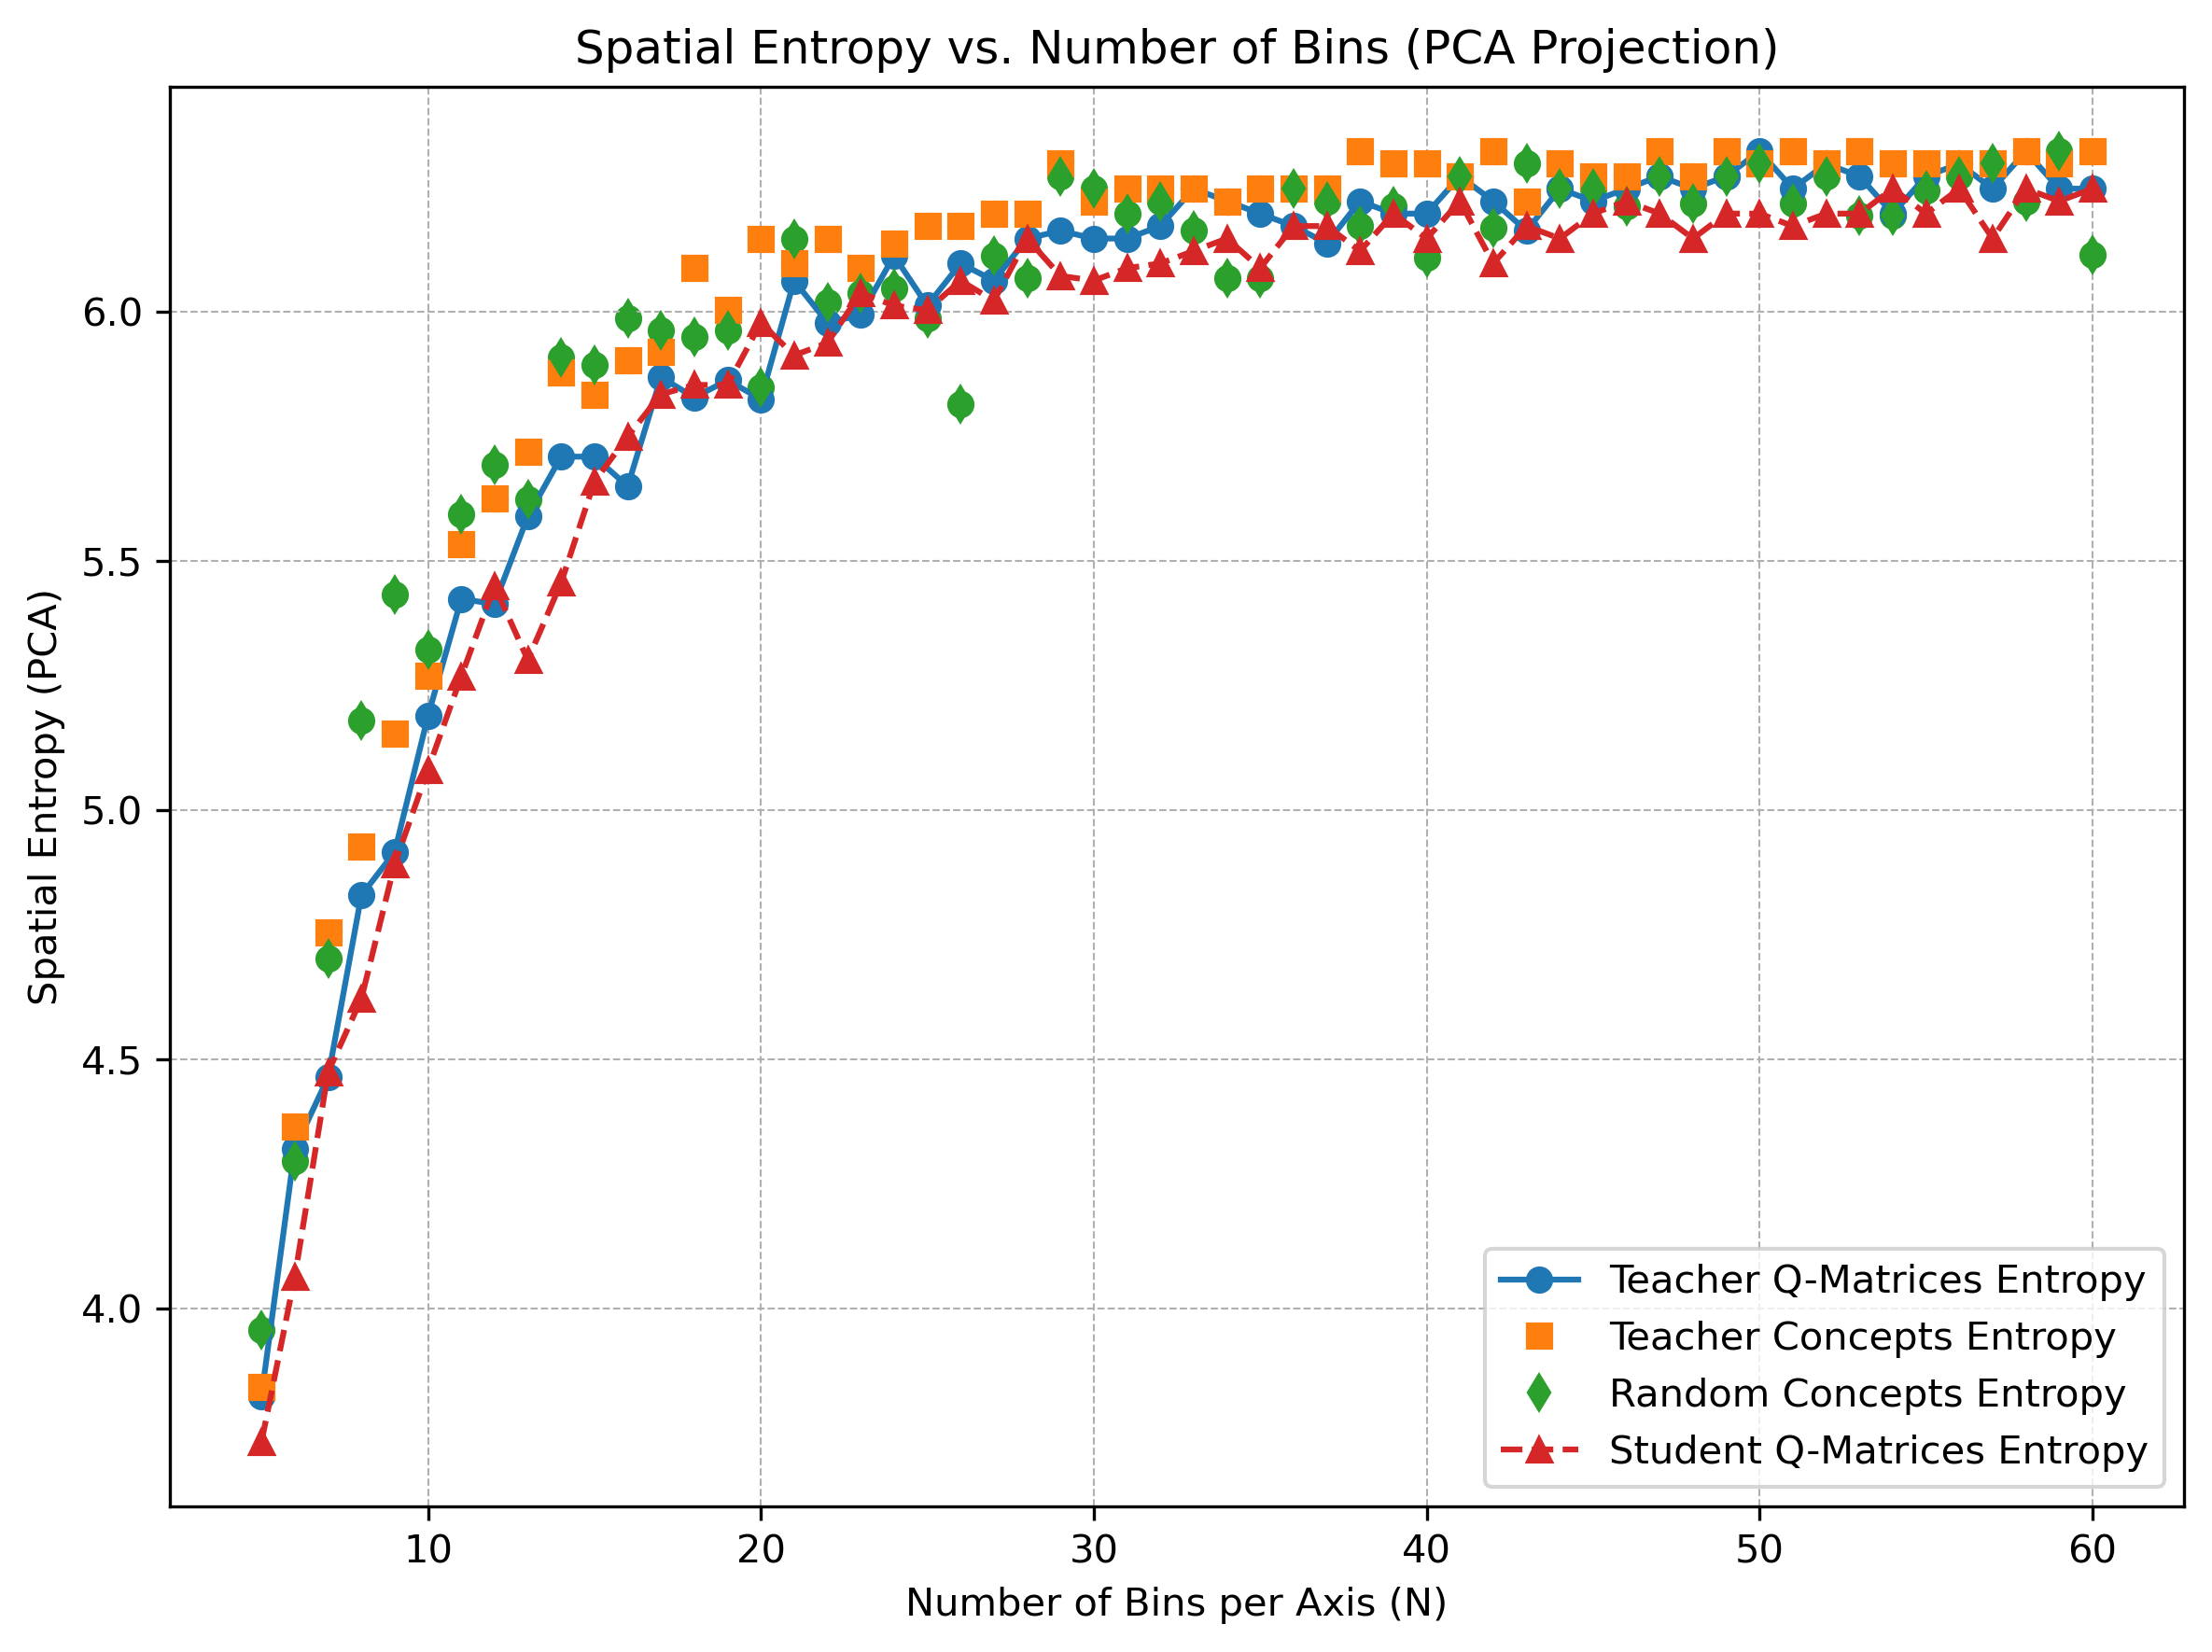


Entropy Values:
Bins | Teacher Q | Concepts | Student Q
-----|-----------|----------|-----------
   5 |    3.8242 |   3.8419 |    3.7316
   6 |    4.3203 |   4.3654 |    4.0630
   7 |    4.4636 |   4.7536 |    4.4739
   8 |    4.8287 |   4.9266 |    4.6212
   9 |    4.9156 |   5.1526 |    4.8914
  10 |    5.1885 |   5.2702 |    5.0812
  11 |    5.4235 |   5.5342 |    5.2681
  12 |    5.4135 |   5.6247 |    5.4497
  13 |    5.5891 |   5.7186 |    5.3013
  14 |    5.7092 |   5.8781 |    5.4559
  15 |    5.7092 |   5.8342 |    5.6592
  16 |    5.6497 |   5.9031 |    5.7497
  17 |    5.8686 |   5.9186 |    5.8342
  18 |    5.8281 |   6.0875 |    5.8531
  19 |    5.8625 |   6.0031 |    5.8531
  20 |    5.8247 |   6.1469 |    5.9781
  21 |    6.0625 |   6.0969 |    5.9125
  22 |    5.9781 |   6.1469 |    5.9375
  23 |    5.9936 |   6.0875 |    6.0375
  24 |    6.1125 |   6.1375 |    6.0125
  25 |    6.0125 |   6.1719 |    6.0031
  26 |    6.0969 |   6.1719 |    6.0625
  27 |    6.0625 |   6

In [9]:
# Define the range of bin sizes
bin_sizes = range(5, 61, 1)

# Initialize lists to store entropy values
entropies_teacher_q = []
entropies_concepts = []
entropies_student_q = []
entropies_rand_concepts = []

# Calculate entropy for each bin size
print("Calculating entropies...")
for n_bins in tqdm(bin_sizes):
    # Calculate entropy using PCA for each dataset
    entropy_tq = calculate_spatial_entropy_torch(teacher_q_matrices, method='pca', n_bins_per_axis=n_bins)
    entropy_c = calculate_spatial_entropy_torch(teacher_concepts, method='pca', n_bins_per_axis=n_bins)
    entropy_rc = calculate_spatial_entropy_torch(torch.rand_like(teacher_concepts), method='pca', n_bins_per_axis=n_bins)
    entropy_sq = calculate_spatial_entropy_torch(student_q_matrices, method='pca', n_bins_per_axis=n_bins)

    # Append results
    entropies_teacher_q.append(entropy_tq)
    entropies_concepts.append(entropy_c)
    entropies_rand_concepts.append(entropy_rc)
    entropies_student_q.append(entropy_sq)
print("Entropy calculation complete.")

# Plot the results
plt.figure(figsize=(8, 6), dpi=300)

# Plot Teacher Q-Matrices entropy
plt.plot(bin_sizes, entropies_teacher_q, marker='o', linestyle='-', label='Teacher Q-Matrices Entropy')
plt.scatter(bin_sizes, entropies_teacher_q, marker='')

# Plot Teacher Concepts entropy
plt.plot(bin_sizes, entropies_concepts, marker='s', linestyle='', label='Teacher Concepts Entropy')
plt.scatter(bin_sizes, entropies_concepts)

# Plot Random Concepts entropy
plt.plot(bin_sizes, entropies_rand_concepts, marker='d', linestyle='', label='Random Concepts Entropy')
plt.scatter(bin_sizes, entropies_rand_concepts)

# Plot Student Q-Matrices entropy
plt.plot(bin_sizes, entropies_student_q, marker='^', linestyle='--', label='Student Q-Matrices Entropy')
plt.scatter(bin_sizes, entropies_student_q, marker='')

# Add labels and title
plt.xlabel('Number of Bins per Axis (N)')
plt.ylabel('Spatial Entropy (PCA)')
plt.title('Spatial Entropy vs. Number of Bins (PCA Projection)')
# plt.xticks(bin_sizes) # Ensure all integer bin sizes are shown as ticks
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Print the results (optional)
print("\nEntropy Values:")
print("Bins | Teacher Q | Concepts | Student Q")
print("-----|-----------|----------|-----------")
for i, n_bins in enumerate(bin_sizes):
    print(f"{n_bins:4d} | {entropies_teacher_q[i]:9.4f} | {entropies_concepts[i]:8.4f} | {entropies_student_q[i]:9.4f}")


In [ ]:
# Ensure the lists are of the same length
if len(entropies_teacher_q) != len(entropies_student_q):
    raise ValueError("Entropy lists must have the same length for a paired t-test.")

# Convert lists to numpy arrays for the test
teacher_entropies_np = np.array(entropies_teacher_q)
student_entropies_np = np.array(entropies_student_q)

# Perform the paired t-test
# H0: The mean difference between paired observations is zero.
# H1: The mean difference between paired observations (teacher - student) is greater than zero.
#     (Equivalent to: student entropy is less than teacher entropy)
# We use alternative='greater' because ttest_rel calculates t = mean(x-y) / SE(x-y)
# So, if teacher > student, the difference (teacher - student) will be positive.
t_statistic, p_value = stats.ttest_rel(
    teacher_entropies_np,
    student_entropies_np,
    alternative='greater' # Test if teacher_entropy > student_entropy
)

# Print the results
print(f"Paired t-test results (Teacher vs Student Entropy):")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value (one-sided, teacher > student): {p_value:.4f}")

# Interpretation
alpha = 0.05 # Significance level
if p_value < alpha:
    print(f"\nSince p-value ({p_value:.4f}) < alpha ({alpha}), we reject the null hypothesis.")
    print("Conclusion: There is statistically significant evidence that the spatial entropy for student Q-matrices is lower than that for teacher Q-matrices across the tested bin sizes.")
else:
    print(f"\nSince p-value ({p_value:.4f}) >= alpha ({alpha}), we fail to reject the null hypothesis.")
    print("Conclusion: There is not enough statistically significant evidence to conclude that the spatial entropy for student Q-matrices is lower than that for teacher Q-matrices across the tested bin sizes.")

# 7. ANALYSIS - Language Content

In [4]:
concepts = torch.load(f'agent_ckpt/{group_str}concepts_of_all.pt')
all_q_tensor = {}
for i in range(n_agents):
    ii_agent = i + 1
    tmp_all_q = torch.load(f'agent_ckpt/{group_str}qmatrix_{ii_agent}of{n_agents}.pt')
    all_q_tensor[ii_agent] = tmp_all_q

wall_array_dict = torch.load(f"maze_wall_array/wall_array_dict_{grid_dim}x{grid_dim}_n{n_mazes}.pt")

valid_indices = []
for i in range(48): # not include Q(49, actions)
    row = i // 7  # Original row in 7x7 grid (0 at bottom to 6 at top)
    col = i % 7   # Column in 7x7 grid (0 at left to 6 at right)
    if row % 2 == 0 and col % 2 == 0:  # Select odd-numbered rows/columns (0,2,4,6)
        valid_indices.append(i)

all_q_tensor[i_agent] = all_q_tensor[i_agent][:,valid_indices,:]

print(concepts[0].shape)
print(all_q_tensor[i_agent][0].shape)
print(wall_array_dict[0].shape)

/tmp/ipykernel_96108/2790839766.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  concepts = torch.load(f'agent_ckpt/{group_str}concepts_of_all.pt')
/tmp/ipykernel_96108/2

torch.Size([64])
torch.Size([15, 4])
(7, 7)


/tmp/ipykernel_96108/2790839766.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wall_array_dict = torch.load(f"maze_wall_array/wall_array_dict_{grid_dim}x{grid_dim}_n{n_

--- Starting analysis with 260 sampling iterations ---
--- Analysis Complete ---

--- RDM Correlation T-test ---
T-statistic: -15.4525
P-value: 0.0000

--- Generating RDM Distribution Plots ---
RDM plots saved to rdm_distribution_plots.png
------------------------------------------

--- Mutual Information T-test ---
T-statistic: 6.9998
P-value: 0.0000

--- Generating Mutual Information Distribution Plots ---


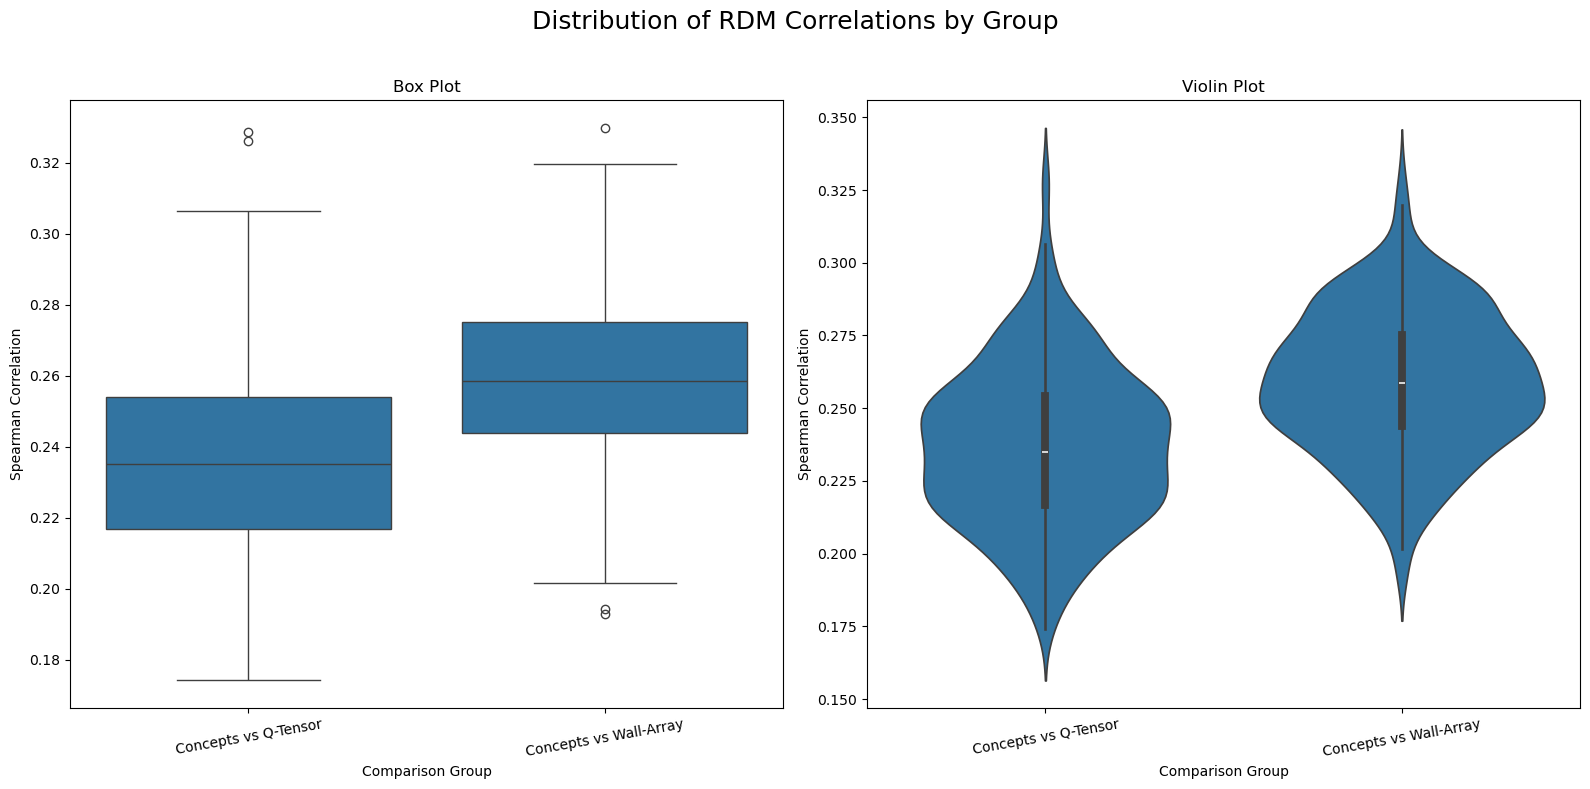

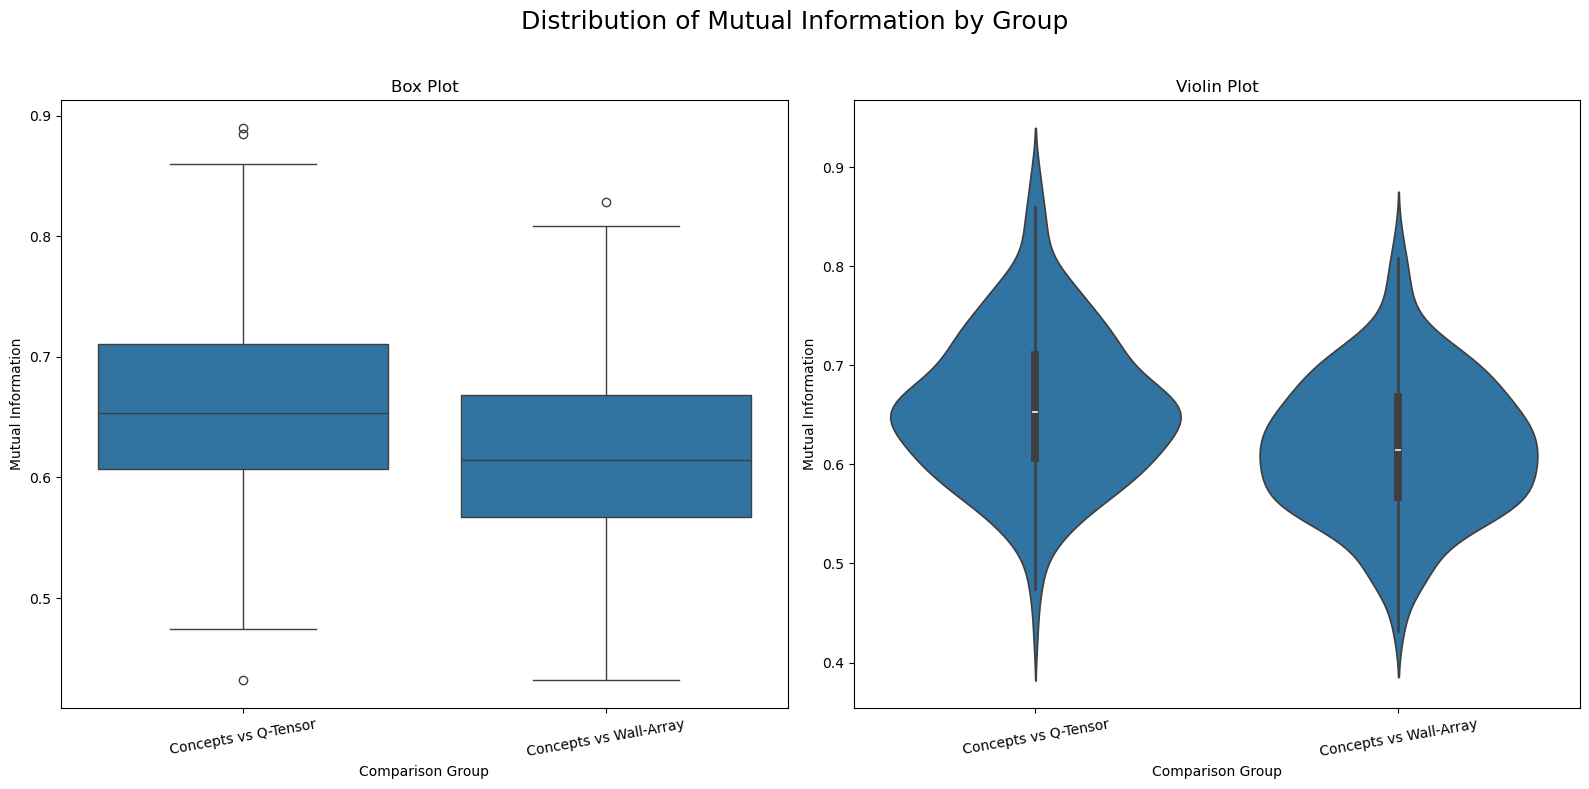

In [5]:
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import mutual_info_score

# --- Step 1, 2, 3, 4: Data Simulation, RDM function, and Analysis Loop ---
# (These parts remain unchanged from the previous robust version)

# # --- Step 1: Simulate Data ---
# print("--- Generating Simulated Data ---")
# n_mazes = 1000
# grid_dim = 7
# n_agents = 1
# concepts = torch.randn(n_mazes, 64)
# all_q_tensor = {
#     i + 1: torch.randn(n_mazes, grid_dim * grid_dim, 4) for i in range(n_agents)
# }
# i_agent = 1
# wall_array_dict = {
#     i: np.random.randint(0, 2, (grid_dim, grid_dim), dtype=bool) for i in range(n_mazes)
# }
# print("--- Data Simulation Complete ---\n")

# --- Step 2: Analysis Parameters & Helper Functions ---
n_samples = 260
n_elements_per_sample = 100

# Lists to store results from both analyses
rdm_correlations_q = []
rdm_correlations_wall = []
mutual_info_q = []
mutual_info_wall = []

# Helper function for RDM (unchanged)
def compute_rdm(data_matrix):
    data_matrix = data_matrix.copy()
    row_std = np.std(data_matrix, axis=1)
    zero_std_rows = np.where(row_std == 0)[0]
    if len(zero_std_rows) > 0:
        noise = np.random.normal(0, 1e-9, (len(zero_std_rows), data_matrix.shape[1]))
        data_matrix[zero_std_rows, :] += noise
    corr_matrix = np.corrcoef(data_matrix)
    corr_matrix = np.nan_to_num(corr_matrix)
    return 1 - corr_matrix

upper_triangle_indices = np.triu_indices(n_elements_per_sample, k=1)

# t-SNE and Binning parameters
tsne_transformer = TSNE(n_components=1, perplexity=15, learning_rate='auto', init='random')
n_bins = 10


# --- Step 3: Main Sampling Loop (with RDM and MI analysis) ---
print(f"--- Starting analysis with {n_samples} sampling iterations ---")
for i in range(n_samples):
    # a. Sample data
    indices = np.random.choice(n_mazes, n_elements_per_sample, replace=False)
    sampled_concepts = concepts[indices].numpy()
    sampled_q_flat = all_q_tensor[i_agent][indices].reshape(n_elements_per_sample, -1).cpu().numpy()
    sampled_walls_flat = np.stack([wall_array_dict[j] for j in indices]).reshape(n_elements_per_sample, -1).astype(float)
    
    # --- b. RDM Analysis ---
    rdm_concepts = compute_rdm(sampled_concepts)
    rdm_q = compute_rdm(sampled_q_flat)
    rdm_wall = compute_rdm(sampled_walls_flat)
    
    vec_rdm_concepts = rdm_concepts[upper_triangle_indices]
    vec_rdm_q = rdm_q[upper_triangle_indices]
    vec_rdm_wall = rdm_wall[upper_triangle_indices]
    
    corr_q, _ = scipy.stats.spearmanr(vec_rdm_concepts, vec_rdm_q)
    rdm_correlations_q.append(corr_q)

    corr_wall, _ = scipy.stats.spearmanr(vec_rdm_concepts, vec_rdm_wall)
    rdm_correlations_wall.append(corr_wall)
    
    # --- c. Mutual Information (MI) Analysis ---
    # Reduce dimensionality with t-SNE
    tsne_concepts = tsne_transformer.fit_transform(sampled_concepts)
    tsne_q = tsne_transformer.fit_transform(sampled_q_flat)
    tsne_walls = tsne_transformer.fit_transform(sampled_walls_flat)
    
    # Discretize the 1D t-SNE output into bins
    binned_concepts = pd.cut(tsne_concepts.flatten(), bins=n_bins, labels=False, duplicates='drop')
    binned_q = pd.cut(tsne_q.flatten(), bins=n_bins, labels=False, duplicates='drop')
    binned_walls = pd.cut(tsne_walls.flatten(), bins=n_bins, labels=False, duplicates='drop')
    
    # Calculate and store mutual information
    mi_q_score = mutual_info_score(binned_concepts, binned_q)
    mutual_info_q.append(mi_q_score)
    
    mi_wall_score = mutual_info_score(binned_concepts, binned_walls)
    mutual_info_wall.append(mi_wall_score)

print("--- Analysis Complete ---\n")


# --- Step 4: RDM Analysis Results ---
print("--- RDM Correlation T-test ---")
ttest_result_rdm = scipy.stats.ttest_rel(rdm_correlations_q, rdm_correlations_wall, nan_policy='omit')
print(f"T-statistic: {ttest_result_rdm.statistic:.4f}")
print(f"P-value: {ttest_result_rdm.pvalue:.4f}\n")

print("--- Generating RDM Distribution Plots ---")
df_rdm = pd.DataFrame({
    'Correlation': rdm_correlations_q + rdm_correlations_wall,
    'Group': (['Concepts vs Q-Tensor'] * len(rdm_correlations_q) + ['Concepts vs Wall-Array'] * len(rdm_correlations_wall))
})
fig_rdm, axes_rdm = plt.subplots(1, 2, figsize=(16, 8))
fig_rdm.suptitle('Distribution of RDM Correlations by Group', fontsize=18)
sns.boxplot(ax=axes_rdm[0], x='Group', y='Correlation', data=df_rdm).set(title='Box Plot', xlabel='Comparison Group', ylabel='Spearman Correlation')
sns.violinplot(ax=axes_rdm[1], x='Group', y='Correlation', data=df_rdm).set(title='Violin Plot', xlabel='Comparison Group', ylabel='Spearman Correlation')
for ax in axes_rdm: ax.tick_params(axis='x', rotation=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("rdm_distribution_plots.png")
print("RDM plots saved to rdm_distribution_plots.png")
print("------------------------------------------\n")


# --- Step 5: Mutual Information Analysis Results ---
print("--- Mutual Information T-test ---")
ttest_result_mi = scipy.stats.ttest_rel(mutual_info_q, mutual_info_wall, nan_policy='omit')
print(f"T-statistic: {ttest_result_mi.statistic:.4f}")
print(f"P-value: {ttest_result_mi.pvalue:.4f}\n")

print("--- Generating Mutual Information Distribution Plots ---")
df_mi = pd.DataFrame({
    'Mutual Information': mutual_info_q + mutual_info_wall,
    'Group': (['Concepts vs Q-Tensor'] * len(mutual_info_q) + ['Concepts vs Wall-Array'] * len(mutual_info_wall))
})
fig_mi, axes_mi = plt.subplots(1, 2, figsize=(16, 8))
fig_mi.suptitle('Distribution of Mutual Information by Group', fontsize=18)
sns.boxplot(ax=axes_mi[0], x='Group', y='Mutual Information', data=df_mi).set(title='Box Plot', xlabel='Comparison Group', ylabel='Mutual Information')
sns.violinplot(ax=axes_mi[1], x='Group', y='Mutual Information', data=df_mi).set(title='Violin Plot', xlabel='Comparison Group', ylabel='Mutual Information')
for ax in axes_mi: ax.tick_params(axis='x', rotation=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 8. ANALYSIS - Linguistic Basic Unit

## 8.1 ICA

Original torch tensor shape: torch.Size([3800, 64])



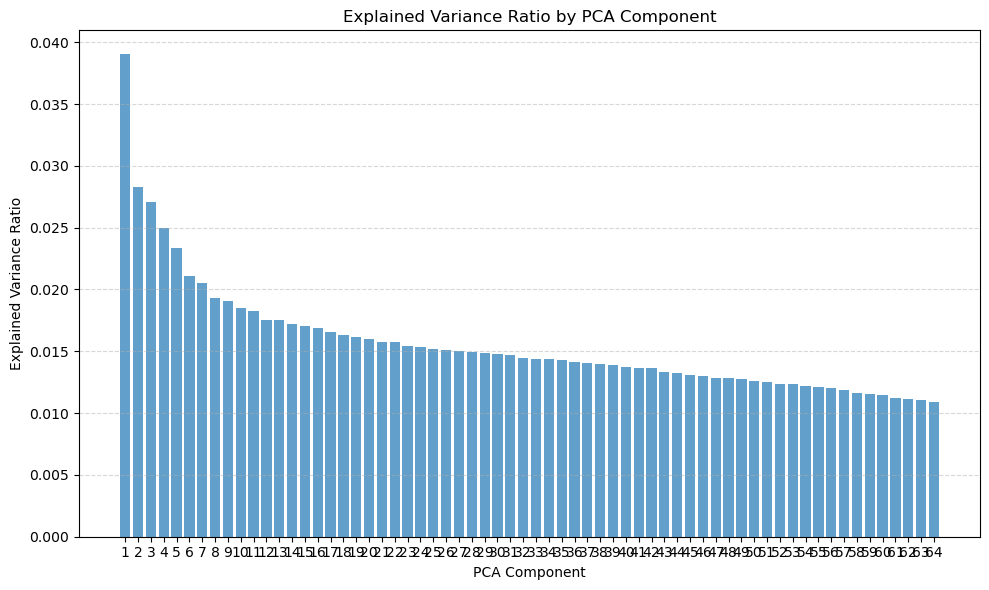

--- PCA Analysis ---
Number of components to explain 95% variance: 56
Total variance explained by these 56 components: 0.9094

--- ICA Analysis ---
Running FastICA with n_components = 56...

Shape of the resulting independent components: (3800, 56)


/data0/user/lxguo/.conda/envs/multi_agent_maze/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [10]:
from sklearn.decomposition import PCA, FastICA

# --- 1. Data Preparation (same as before) ---
print(f"Original torch tensor shape: {concepts.shape}\n")

# Convert the torch.Tensor to a NumPy array for scikit-learn
data_numpy = concepts.cpu().numpy()


# --- 2. Use PCA to determine the number of components ---

# Create a PCA object to analyze all components
pca = PCA(svd_solver='full')
pca.fit(data_numpy)

# Calculate the cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by PCA Component')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Find the number of components needed to explain 99% of the variance
# np.argmax returns the first index where the condition is True. Add 1 for the count.
n_components_pca = np.argmax(cumulative_variance >= 0.90) + 1

print(f"--- PCA Analysis ---")
print(f"Number of components to explain 95% variance: {n_components_pca}")
print(f"Total variance explained by these {n_components_pca} components: {cumulative_variance[n_components_pca-1]:.4f}\n")


# --- 3. Apply FastICA with the determined number of components ---

print(f"--- ICA Analysis ---")
print(f"Running FastICA with n_components = {n_components_pca}...")

# Initialize and apply FastICA using the number of components from PCA
ica = FastICA(n_components=n_components_pca, random_state=0, whiten='unit-variance', max_iter=500)

# Fit the model and get the independent components
independent_components = ica.fit_transform(data_numpy)

if independent_components is not None:
    print(f"\nShape of the resulting independent components: {independent_components.shape}")
else:
    print("\nFastICA did not converge or returned None.")

# Optional: Convert back to a torch tensor if needed
# if independent_components is not None:
#     independent_components_tensor = torch.from_numpy(independent_components).float()

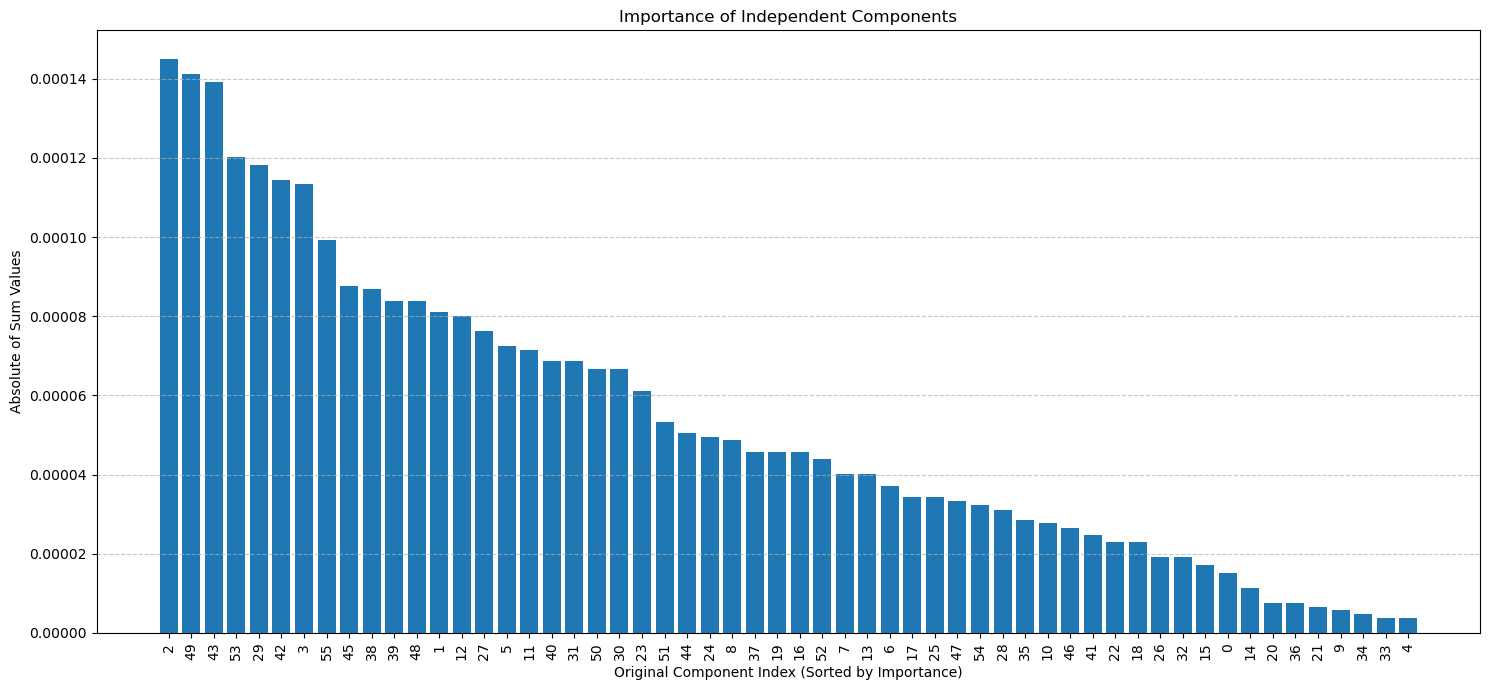

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Take the absolute value of the independent components
# abs_components = np.abs(independent_components)
abs_components = independent_components

# 2. Sum the absolute values along dimension 0 (over all samples)
sum_abs_over_samples = np.abs(np.sum(abs_components, axis=0))

# 3. Get the indices that would sort the sums in descending order
sorted_indices = np.argsort(sum_abs_over_samples)[::-1]

# Sort the sums for plotting
sorted_sums = sum_abs_over_samples[sorted_indices]

# 4. Create the bar plot
plt.figure(figsize=(15, 7))
# We use a simple range for x positions and then label them with the original indices
x_positions = np.arange(len(sorted_sums))
plt.bar(x_positions, sorted_sums)

# Set the x-tick labels to be the original component indices, sorted by importance
plt.xticks(x_positions, sorted_indices, rotation=90)

plt.xlabel('Original Component Index (Sorted by Importance)')
plt.ylabel('Absolute of Sum Values')
plt.title('Importance of Independent Components')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 8.2 Menzerath Law

In [29]:
def graph_from_walls(grid_dim, wall_states):
    '''
    Creates a graph representing the gridworld without walls.
    
    Parameters:
    grid_dim (int): The dimension of the grid.
    wall_states (list of int): Positions that are walls.
    
    Returns:
    G (nx.Graph): Graph representing the gridworld.
    '''
    G = nx.Graph()
    
    # Add nodes for passable cells
    for s in range(grid_dim**2):
        if s not in wall_states:
            x = s % grid_dim
            y = mt.floor(s / grid_dim)
            G.add_node(s, pos=(x, y))
    
    # Add edges between adjacent passable cells
    for s1 in range(grid_dim**2):
        if s1 in G.nodes:
            # Check right neighbor
            s2 = s1 + 1
            if s2 in G.nodes and (s1 % grid_dim) != grid_dim - 1:
                G.add_edge(s1, s2, weight=1)
            # Check up neighbor
            s2 = s1 + grid_dim
            if s2 in G.nodes and (s1 // grid_dim) != grid_dim - 1:
                G.add_edge(s1, s2, weight=1)
    
    return G

def shortest_path(grid_dim, wall_states, start, goal):
    '''
    Finds the shortest path between two points in the gridworld.
    
    Parameters:
    grid_dim (int): The dimension of the grid.
    wall_states (list of int): Positions that are walls.
    start (int): Start position.
    goal (int): Goal position.
    
    Returns:
    list: The shortest path from start to goal, or an empty list if no path exists.
    '''
    G = graph_from_walls(grid_dim, wall_states)
    
    if start not in G.nodes or goal not in G.nodes:
        return []
    
    try:
        path = nx.shortest_path(G, source=start, target=goal, weight='weight')
    except nx.NetworkXNoPath:
        path = []
    
    return path

def maze_array2states(states_array: np.ndarray) -> list[int]:
    wall_states = []
    n_rows, n_cols = states_array.shape
    for i in range(n_rows - 1, -1, -1):
        for j in range(n_cols):
            if states_array[i, j]:
                pos_code = (n_rows - 1 - i) * n_cols + j
                wall_states.append(pos_code)

    return wall_states
    
wall_array_dict = torch.load(f"maze_wall_array/wall_array_dict_{grid_dim}x{grid_dim}_n{n_mazes}.pt")
wall_state_dict = {}

for i in range(n_mazes):
    wall_state_dict[i] = maze_array2states(wall_array_dict[i])

path = []
count_shortest_path = []
for wall_state_dict_i in wall_state_dict.values():
    path.append(shortest_path(grid_dim, wall_state_dict_i, 0, grid_dim**2 - 1))
    count_shortest_path.append(len(path[-1]))

print(len(count_shortest_path))

/tmp/ipykernel_2072764/220737769.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wall_array_dict = torch.load(f"maze_wall_array/wall_array_dict_{grid_dim}x{grid_dim}_n{

3800


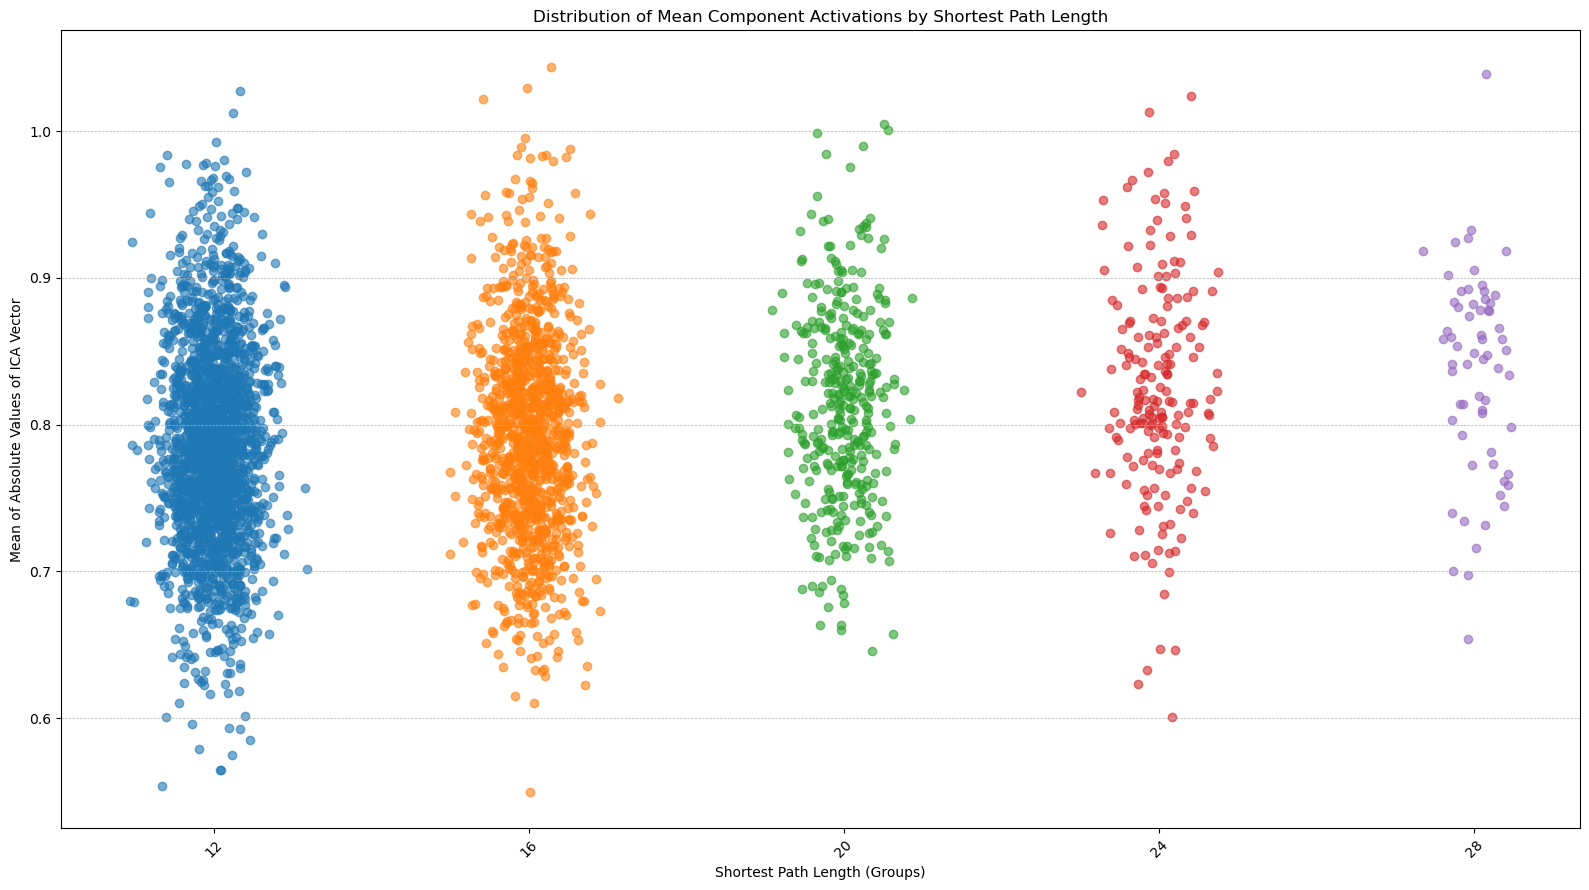

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# This script assumes 'count_shortest_path' (list or array of 3800 integers)
# and 'independent_components' (3800, 56 NumPy array) are already loaded.

# --- Step 1: Group component data by shortest path length ---
# Create a dictionary to hold the lists of mean activations for each path length.
path_length_to_activations = defaultdict(list)

# Check if the lengths match before proceeding
if len(count_shortest_path) != independent_components.shape[0]:
    raise ValueError(f"Mismatch in data length: count_shortest_path has {len(count_shortest_path)} elements "
                     f"while independent_components has {independent_components.shape[0]} rows.")

# Iterate through all the mazes
for i in range(len(count_shortest_path)):
    path_length = count_shortest_path[i] - 1
    component_vector = independent_components[i]
    
    # Calculate the mean of the absolute values for the 56-dimensional vector
    mean_abs_value = np.mean(np.abs(component_vector))
    
    # Append this calculated value to the list for the corresponding path length key
    path_length_to_activations[path_length].append(mean_abs_value)

# --- Step 2: Prepare the data for plotting ---
# Sort the dictionary keys (the unique path lengths) to ensure the x-axis is ordered
sorted_path_lengths = sorted(path_length_to_activations.keys())

# --- Step 3: Create the plot ---
# Initialize the plot with a larger size for better readability
plt.figure(figsize=(16, 9))

# Iterate through each group (path length) to plot its data
for i, path_length in enumerate(sorted_path_lengths):
    # Get the list of mean activation values for the current path length
    values = path_length_to_activations[path_length]
    
    # To prevent points from overlapping perfectly on a vertical line,
    # we add a small amount of random "jitter" to their x-coordinates.
    # This helps visualize the distribution of points within each group.
    x_coords = np.random.normal(i, 0.08, size=len(values))
    
    plt.scatter(x_coords, values, alpha=0.6)

# --- Step 4: Customize and format the plot for clarity ---
# Set the positions and labels for the x-axis ticks
plt.xticks(ticks=range(len(sorted_path_lengths)), labels=sorted_path_lengths, rotation=45)

plt.xlabel('Shortest Path Length (Groups)')
plt.ylabel('Mean of Absolute Values of ICA Vector')
plt.title('Distribution of Mean Component Activations by Shortest Path Length')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()


In [34]:
path_length_to_activations.keys()

dict_keys([16, 12, 20, 28, 24])

## 8.3 Heaps' Law

Starting PCA analysis for sample sizes from 100 to 3800...


Processing sample sizes:   0%|          | 0/371 [00:00<?, ?it/s]

Analysis complete.


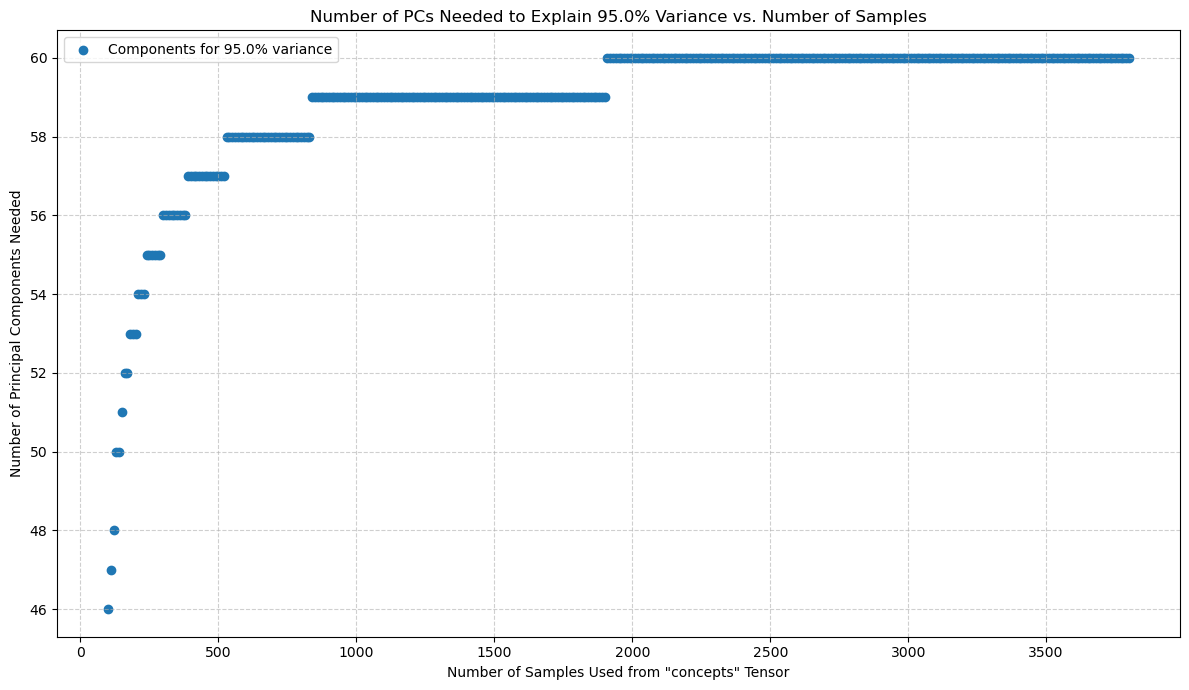

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

# This script assumes the 'concepts' tensor (shape 3800, 64) is already loaded.

# --- Step 1: Initialize for the analysis ---
# List to store the results (number of samples, number of components)
results = []
variance_threshold = 0.95

# Define the range of sample sizes to iterate through
sample_sizes = range(100, 3801, 10)

print(f"Starting PCA analysis for sample sizes from 100 to 3800...")

# --- Step 2: Loop through the data in increasing chunks ---
for i in tqdm(sample_sizes, desc="Processing sample sizes"):
    # Select the first `i` rows (samples) from the concepts tensor
    subset_concepts = concepts[:i, :]
    
    # Convert the PyTorch tensor subset to a NumPy array for scikit-learn
    data_numpy = subset_concepts.cpu().numpy()
    
    # Initialize and fit the PCA model to the current data subset
    pca = PCA(svd_solver='full')
    pca.fit(data_numpy)
    
    # Calculate the cumulative sum of the explained variance ratio
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Find the number of components required to explain at least 95% of the variance
    # We use np.argmax which finds the first index where the condition is True.
    # We add 1 because component indices are 0-based.
    try:
        n_components_needed = np.argmax(cumulative_variance >= variance_threshold) + 1
    except ValueError:
        # This case would be rare but handles if no component set reaches the threshold
        n_components_needed = len(pca.explained_variance_ratio_)
        
    # Record the current sample size (i) and the number of components needed
    results.append((i, n_components_needed))

print("Analysis complete.")

# --- Step 3: Prepare data for plotting ---
# Unzip the results into two separate lists for the x and y axes
x_values = [res[0] for res in results]
y_values = [res[1] for res in results]

# --- Step 4: Create the scatter plot ---
plt.figure(figsize=(12, 7))
plt.scatter(x_values, y_values, marker='o', label=f'Components for {variance_threshold*100}% variance')

# Customize the plot for clarity
plt.xlabel('Number of Samples Used from "concepts" Tensor')
plt.ylabel('Number of Principal Components Needed')
plt.title(f'Number of PCs Needed to Explain {variance_threshold*100}% Variance vs. Number of Samples')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Show the final plot
plt.show()
